In [90]:
import os
import re
import h5py
import struct
import numpy as np
import configparser
import matplotlib.pyplot as plt

In [42]:
config = configparser.ConfigParser()
config.read('file_paths.ini')
config.sections()

['MAIN_DATA_PATH', 'FY3', 'HIMAWARI']

In [43]:
# File paths for FengYun-3E data.
FY3E_DATA_FOLDERS_LOCATION = config['FY3']['FY3E_MAIN_DATA_LOCATION']
FY3E_RAW_DATA_LOCATION = config['FY3']['FY3E_RAW_DATA_LOCATION']
FY3E_L0_DATA_LOCATION = config['FY3']['FY3E_L0_DATA_LOCATION']
FY3E_L1_DATA_LOCATION = config['FY3']['FY3E_L1_DATA_LOCATION']
FY3E_L1_GOE_DATA_LOCATION = config['FY3']['FY3E_L1_GOE_DATA_LOCATION']
FY3E_L1_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_IMAGE_DATA_LOCATION']
FY3E_L1_GEOREF_IMAGE_DATA_LOCATION = config['FY3']['FY3E_L1_GEOREF_IMAGE_DATA_LOCATION']

In [44]:
fy3e_L0_files_paths = [FY3E_L0_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L0_DATA_LOCATION)]
fy3e_l1_geo_files_paths = [FY3E_L1_GOE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_GOE_DATA_LOCATION)]
fy3e_l1_image_files_paths = [FY3E_L1_IMAGE_DATA_LOCATION + file_name for file_name in os.listdir(FY3E_L1_IMAGE_DATA_LOCATION)]

print('L0 files -', fy3e_L0_files_paths)
print()
print('GEO files -', fy3e_l1_geo_files_paths)
print()
print('Image files -', fy3e_l1_image_files_paths)

L0 files - ['E:/Satellite data/FY-3E/L0/Y3E_08534_230226070855_7860R_MERSI.DAT']

GEO files - ['E:/Satellite data/FY-3E/L1/geo/FY3E_MERSI_GRAN_L1_20230228_2215_GEOQK_V0.HDF']

Image files - ['E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230228_2215_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20240301_0915_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0435_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230128_0935_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0520_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0840_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_0845_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1020_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_1745_0250M_V0.HDF', 'E:/Satellite data/FY-3E/L1/image/FY3E_MERSI_GRAN_L1_20230131_2100_0250

In [45]:
data = h5py.File(fy3e_l1_image_files_paths[0])

In [40]:
np.array(data['Calibration']['SV_DN_Average_Emissive']).shape

(2, 200)

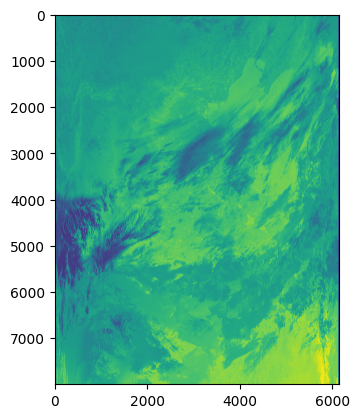

In [6]:
plt.imshow(np.array(data['Data']['EV_250_Emissive_b6']))

In [91]:
def find_synchroseries(byte_line: bytes) -> np.array:
    synchroseries = b'\x00\x00\x00\x00\x00\x00\x00\x00\x00d'
    return np.array([i.start() for i in re.finditer(synchroseries, byte_line)])

In [47]:
def read_uint12(data_chunk):
    data = np.frombuffer(data_chunk, dtype=np.uint8)
    fst_uint8, mid_uint8, lst_uint8 = np.reshape(data, (data.shape[0] // 3, 3)).astype(np.uint16).T
    fst_uint12 = (fst_uint8 << 4) + (mid_uint8 >> 4)
    snd_uint12 = ((mid_uint8 % 16) << 8) + lst_uint8
    return np.reshape(np.concatenate((fst_uint12[:, None], snd_uint12[:, None]), axis=1), 2 * fst_uint12.shape[0])

In [171]:
l0_data = open(fy3e_L0_files_paths[0], 'br')

In [172]:
header_size = 1331906 - 119938 - 52424
header_size

1159544

In [173]:
data = l0_data.read(header_size)

In [174]:
section_1, section_2 = [], []
section_3, section_4, section_5, section_6, section_7 = [], [], [], [], []

data1_agg, data2_agg, data3_agg, data4_agg = [], [], [], []

hyperX_data_agg = []

for _ in range(500):
    data1 = l0_data.read(554)
    data1_agg.append(data1)

    data2 = l0_data.read(25930)
    data2_agg.append(data2)

    data3 = l0_data.read(17290)
    data3_agg.append(data3)

    data4 = l0_data.read(8650)
    data4_agg.append(data4)

    # hyperX_data = l0_data.read(52424)
    # hyperX_data_agg.append(hyperX_data)
    
    for i in range(40):
        data = l0_data.read(9226)
        section_1.append(read_uint12(data[10:]))

    for i in range(40):
        data = l0_data.read(9226)
        section_2.append(read_uint12(data[10:]))
        
    for i in range(40):
        data = l0_data.read(9226)
        
        section_3.append(read_uint12(data[10:2314]))
        section_4.append(read_uint12(data[2314:4618]))
        section_5.append(read_uint12(data[4618:6922]))
        section_6.append(read_uint12(data[6922:9226]))


section_1 = np.array(section_1)
section_2 = np.array(section_2)
section_3 = np.array(section_3)
section_4 = np.array(section_4)
section_5 = np.array(section_5)
section_6 = np.array(section_6)

In [105]:
plt.imsave('b6.png', section_1)

In [80]:
data3 = np.array(data2_agg)

In [92]:
find_synchroseries(data3[1])

array([0])

In [96]:
test_data3 = data3[1][10:]

In [100]:
sv_block_size = 216

In [101]:
sv_blocks = []
for block_index in range(0, 25920, sv_block_size):
    sv_blocks.append(read_uint12(test_data3[block_index:block_index + sv_block_size]))

sv_blocks = np.array(sv_blocks)

In [108]:
sv_blocks.shape

(120, 144)

In [135]:
sv_blocks[0].shape[0]

144

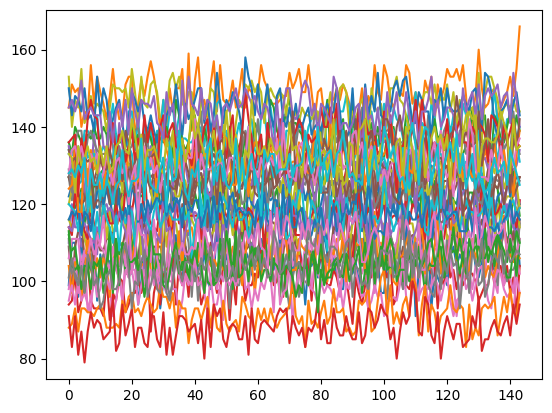

In [144]:
for i in range(40):
    plt.plot(np.arange(sv_blocks.shape[1]), sv_blocks[i])

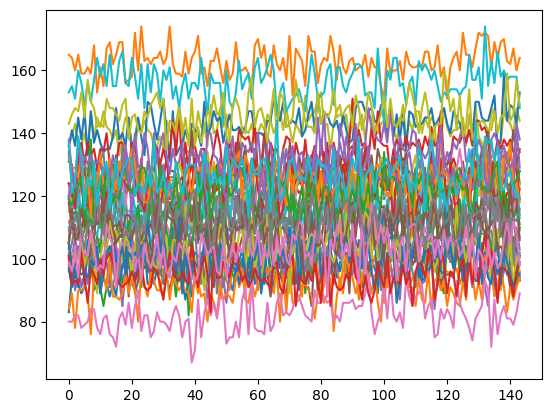

In [150]:
for i in range(40):
    plt.plot(np.arange(sv_blocks.shape[1]), sv_blocks[40 + i])

In [112]:
for index, i in enumerate(sv_blocks[80:120]):
    print(index, i)

0 [200 203 199 202 198 204 203 202 203 202 204 199 201 201 202 202 204 202
 202 204 204 202 201 199 204 201 203 199 202 197 203 204 207 200 202 204
 169 170 167 168 166 171 172 169 170 171 168 165 169 168 169 169 169 168
 170 169 168 169 167 168 171 167 171 166 170 166 173 169 171 166 170 169
 186 191 188 188 185 191 192 191 189 190 185 188 189 188 186 190 191 186
 189 190 187 190 187 188 191 189 191 187 188 186 194 190 193 188 191 189
 181 186 181 181 182 185 187 187 181 185 181 182 182 183 183 183 184 180
 187 184 183 186 183 182 186 183 185 182 184 181 188 184 188 181 185 185]
1 [184 187 185 183 185 187 190 188 186 188 184 184 185 188 185 186 189 184
 188 189 185 185 187 185 191 186 189 185 186 183 190 187 189 184 188 187
 220 223 220 219 219 221 226 221 219 222 216 218 221 223 219 221 221 220
 221 222 221 222 221 219 225 222 222 220 221 218 224 220 225 222 222 222
 220 223 217 218 218 219 226 221 219 223 217 218 221 223 218 218 221 221
 221 223 221 222 221 220 226 218 224 220 220 2

In [205]:
sv_blocks[97:98][0][72:108]

array([1933, 1900, 1923, 1899, 1925, 1914, 1925, 1911, 1905, 1905, 1922,
       1931, 1935, 1943, 1922, 1939, 1954, 1937, 1942, 1953, 1952, 1955,
       1946, 1965, 1947, 1962, 1970, 1999, 1982, 1935, 1978, 1982, 1978,
       1973, 1991, 1984], dtype=uint16)

In [181]:
test_data4 = data3_agg[1][10:]

In [182]:
bb_block_size = 144

In [184]:
bb_blocks = []
for block_index in range(0, 17280, bb_block_size):
    bb_blocks.append(read_uint12(test_data4[block_index:block_index + bb_block_size]))

bb_blocks = np.array(bb_blocks)

In [186]:
bb_blocks.shape

(120, 96)

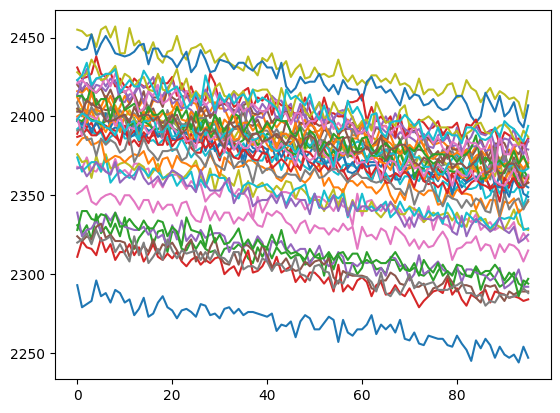

In [187]:
for i in range(40):
    plt.plot(np.arange(bb_blocks.shape[1]), bb_blocks[i])

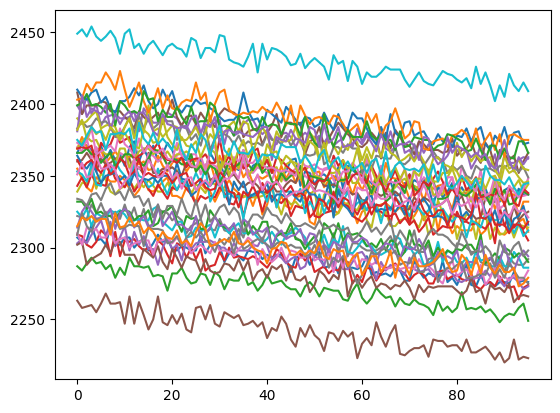

In [188]:
for i in range(40):
    plt.plot(np.arange(bb_blocks.shape[1]), bb_blocks[40 + i])

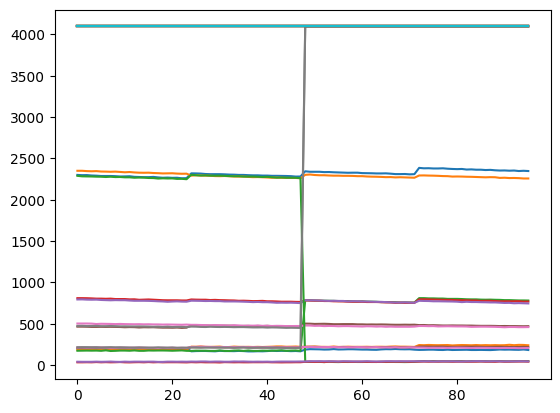

In [193]:
for i in range(40):
    plt.plot(np.arange(bb_blocks.shape[1]), bb_blocks[80 + i])

In [195]:
bb_blocks[40:]

array([[2307, 2304, 2305, ..., 2276, 2277, 2276],
       [2355, 2348, 2342, ..., 2318, 2320, 2311],
       [2287, 2284, 2289, ..., 2258, 2261, 2249],
       ...,
       [4095, 4095, 4095, ..., 4095, 4095, 4095],
       [4095, 4095, 4095, ..., 4095, 4095, 4095],
       [4095, 4095, 4095, ..., 4095, 4095, 4095]], dtype=uint16)